In [1]:
import pandas as pd
import numpy as np
import warnings
import sys, os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

sys.path.append(os.path.abspath('..'))

ais_type_label_path = '../../data/labels/ais_type_labels_radar_detections.csv'
matrix_path = 'track_matrices/'

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

import warnings
warnings.filterwarnings("ignore", message="Failed to load image Python extension")

Using device: mps


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNBaseline(nn.Module):
    def __init__(self, in_channels, num_hidden_1, num_hidden_2, num_hidden_3, num_classes):
        super(CNNBaseline, self).__init__()
        self.in_channels = in_channels
        self.num_hidden_1 = num_hidden_1
        self.num_hidden_2 = num_hidden_2
        self.num_hidden_3 = num_hidden_3
        self.num_classes = num_classes
        
        self.features = nn.Sequential(
            # Conv Block 1
            # Input: INPUT_CHANNELS*224*224
            nn.Conv2d(in_channels=self.in_channels, out_channels=self.num_hidden_1, kernel_size=3, padding=1),  # -> (h1, 224, 224)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # -> (h1, 112, 112)
            nn.Dropout(p=0.25),

            # Conv Block 2
            nn.Conv2d(self.num_hidden_1, self.num_hidden_2, kernel_size=3, padding=1),  # -> (h2, 112, 112)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # -> (h2, 56, 56)
            nn.Dropout(p=0.25),

            # Conv Block 3
            nn.Conv2d(self.num_hidden_2, self.num_hidden_3, kernel_size=3, padding=1),  # -> (h3, 56, 56)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # -> (h3, 28, 28)
            nn.Dropout(p=0.25)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),  # -> (h3 * 28 * 28)
            nn.Linear(self.num_hidden_3 * 28 * 28, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, self.num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x



In [5]:
BATCH_SIZE = 32
NUM_HIDDEN_1 = 16
NUM_HIDDEN_2 = 32
NUM_HIDDEN_3 = 64

from core.DICT import TYPE_to_LABEL
NUM_CLASSES = len(TYPE_to_LABEL)

In [6]:
from dataloader_matrix import get_type_datasets

train_loader, val_loader, test_loader = get_type_datasets(ais_type_label_path, matrix_path, batch_size = BATCH_SIZE)

In [7]:
for batch in train_loader:
    X, y = batch
    print(X.shape, y.shape)
    break

torch.Size([32, 3, 224, 224]) torch.Size([32])


In [6]:
from PIL import Image

X_0 = X[0]
img = X_0[0:3, :, :]
img = img.numpy().astype(np.uint8)
img = np.transpose(img, (1, 2, 0))
image = Image.fromarray(img)
image.show()

In [6]:
y


tensor([1, 2, 1, 2, 3, 4, 0, 1, 1, 1, 0, 6, 0, 1, 1, 2, 1, 2, 2, 0, 2, 0, 1, 6,
        5, 0, 1, 2, 3, 1, 1, 2])

In [10]:
from cnn_training import train

cnn_baseline_matrix = CNNBaseline(
    in_channels = X.shape[1], 
    num_hidden_1 = NUM_HIDDEN_1, 
    num_hidden_2 = NUM_HIDDEN_2, 
    num_hidden_3 = NUM_HIDDEN_3, 
    num_classes = NUM_CLASSES).to(device)

train_config = {
    "model": cnn_baseline_matrix,
    "train_loader" : train_loader,
    "val_loader" : val_loader,
    "optimizer" : optim.Adam(cnn_baseline_matrix.parameters(), lr=1e-3),
    "device" : device,
    "num_epochs" : 20,
    "scheduler": None
}

TRAIN_LOSSES, TRAIN_ACC, VAL_LOSSES, VAL_ACC, best_model_wts, best_val_loss = train(**train_config)

Epoch 1/20
Train Loss: 1.1541 | Train Acc: 0.6484
Val   Loss: 0.9676 | Val   Acc: 0.6690


Epoch 2/20
Train Loss: 0.8889 | Train Acc: 0.6983
Val   Loss: 0.9306 | Val   Acc: 0.6979


Epoch 3/20
Train Loss: 0.8180 | Train Acc: 0.7262
Val   Loss: 0.9044 | Val   Acc: 0.6965


Epoch 4/20
Train Loss: 0.7361 | Train Acc: 0.7504
Val   Loss: 0.8715 | Val   Acc: 0.7028


Epoch 5/20
Train Loss: 0.6670 | Train Acc: 0.7734
Val   Loss: 0.8989 | Val   Acc: 0.6965


Epoch 6/20
Train Loss: 0.5989 | Train Acc: 0.7949
Val   Loss: 0.8830 | Val   Acc: 0.6915


Epoch 7/20
Train Loss: 0.5384 | Train Acc: 0.8148
Val   Loss: 0.9275 | Val   Acc: 0.6937


Epoch 8/20
Train Loss: 0.4806 | Train Acc: 0.8366
Val   Loss: 0.9896 | Val   Acc: 0.6944


Epoch 9/20
Train Loss: 0.4168 | Train Acc: 0.8556
Val   Loss: 1.0591 | Val   Acc: 0.6937


Epoch 10/20
Train Loss: 0.3697 | Train Acc: 0.8801
Val   Loss: 1.0582 | Val   Acc: 0.7000


Epoch 11/20
Train Loss: 0.3233 | Train Acc: 0.8894
Val   Loss: 1.2110 | Val   Acc: 0.7000


Epoch 12/20
Train Loss: 0.3069 | Train Acc: 0.8960
Val   Loss: 1.1691 | Val   Acc: 0.6937


Epoch 13/20
Train Loss: 0.2768 | Train Acc: 0.9064
Val   Loss: 1.2068 | Val   Acc: 0.7028


Epoch 14/20
Train Loss: 0.2515 | Train Acc: 0.9151
Val   Loss: 1.4404 | Val   Acc: 0.6845


Epoch 15/20
Train Loss: 0.2302 | Train Acc: 0.9230
Val   Loss: 1.3983 | Val   Acc: 0.6979


Epoch 16/20
Train Loss: 0.1988 | Train Acc: 0.9329
Val   Loss: 1.5569 | Val   Acc: 0.7077


Epoch 17/20
Train Loss: 0.1760 | Train Acc: 0.9418
Val   Loss: 1.5937 | Val   Acc: 0.6831


Epoch 18/20
Train Loss: 0.1764 | Train Acc: 0.9404
Val   Loss: 1.6323 | Val   Acc: 0.6923


Epoch 19/20
Train Loss: 0.1673 | Train Acc: 0.9460
Val   Loss: 1.6014 | Val   Acc: 0.7028


Epoch 20/20
Train Loss: 0.1512 | Train Acc: 0.9490
Val   Loss: 1.7766 | Val   Acc: 0.6873


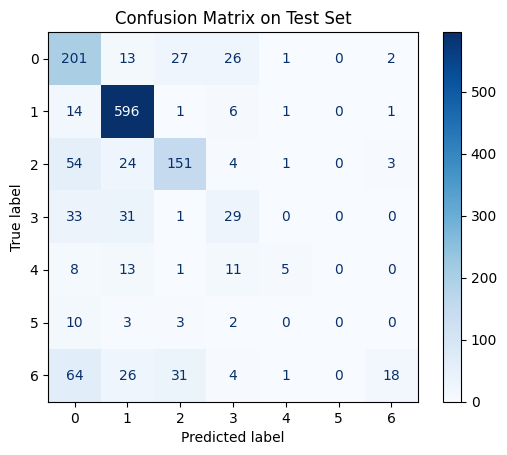

In [9]:
# Load best weights
cnn_baseline_matrix.load_state_dict(best_model_wts)
cnn_baseline_matrix.eval()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import matplotlib.pyplot as plt

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_baseline_matrix(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Test Set")
plt.show()


In [10]:
import matplotlib.pyplot as plt
import os

# Make sure plots/ folder exists
os.makedirs("plots", exist_ok=True)

# Plot losses
plt.figure(figsize=(10, 6))
plt.plot(TRAIN_LOSSES, label='Train Loss', marker='o')
plt.plot(VAL_LOSSES, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN Baseline Matrix Loss')
# Add best validation loss below the title
plt.text(0.5, 1.02, f'Best Validation Loss: {best_val_loss:.4f}',
         transform=plt.gca().transAxes,
         ha='center', fontsize=10, color='gray')
plt.legend()
plt.grid(True)

# Save the figure
plt.savefig("plots/cnn_baseline_matrix_loss.png")
plt.close()  # Close the figure to avoid memory issues if plotting repeatedly

torch.save(best_model_wts, "models/cnn_baseline_matrix_20.pth")
